# Reconstruct audio from the power spectrogram
Given a (single) .flac file we want to compute the power spectrogram the same way it gets fed to the model. Once we have this power spectrogram we want to perform a spectrogram inversion. The goal is being able to get a good quality audio file from a spectrogram so that we can evaluate the adversarial attacks we will perform on the power spectrograms .


In [2]:
import pandas as pd
import librosa
from src.utils import *
from src.audio_utils import read_audio
import IPython.display as ipd
from src.resnet_features import compute_spectrum

## Preliminaries + get the file + play

In [3]:
config_path = '../config/residualnet_train_config.yaml'
config = read_yaml(config_path)

In [4]:
df_eval = pd.read_csv(os.path.join('..', config["df_eval_path"]))

# get the list of evaluation files and labels
file_eval = list(df_eval['path'])
label_eval = list(df_eval['label'])

# get one single file (given the index)
index = 1
file = file_eval[index]
label = label_eval[index]
print(f'Evaluating file {file} with label {label}')

Evaluating file /nas/public/dataset/asvspoof2021/ASVspoof2021_DF_eval/flac/DF_E_2000013.flac with label 1


In [22]:
X, fs = read_audio(file)
print(f'File {index} is {X.size} samples long with fs={fs}')

File 1 is 51200 samples long with fs=16000


In [6]:
ipd.Audio(file)

## Get the power spectrogram

In [7]:
spec = compute_spectrum(X)

In [8]:
# n_fft = 2048
# hop_length = 512
# frequency bins: 1+n_fft/2 = 1+2048/2 = 1025
# time frames: 1 + [(L-n_fft)/hop_length]
spec.shape

(1025, 97)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f39ed5dae50>


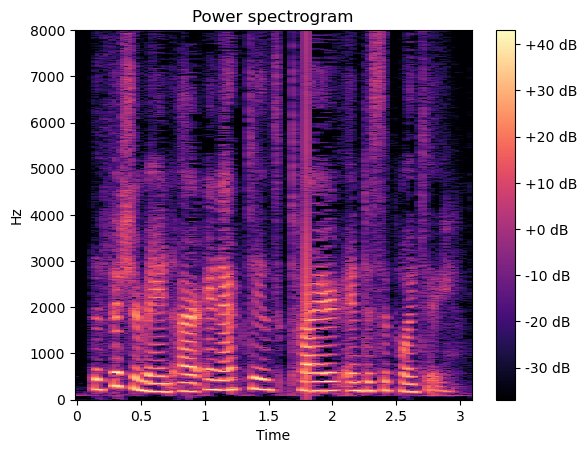

In [21]:
librosa.display.specshow(spec, x_axis='time', y_axis='linear', hop_length=512, sr=16000, cmap='magma')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

## Get the magnitude spectrogram 
from the power spectrogram 


In [10]:
from tests import recover_mag_spec

In [11]:
mag_spec = recover_mag_spec(spec)

In [12]:
mag_spec.shape

(1025, 97)

## SPSI 
Single Pass Spectrogram Inversion

In [13]:
from tests import spsi

In [14]:
SPSI_audio = spsi(msgram=mag_spec, n_fft=2048, hop_length=512)

In [15]:
SPSI_audio.shape

(51200,)

In [16]:
ipd.Audio(SPSI_audio, rate=16000)

## Griffin-Lim

In [17]:
from tests import griffin_lim

## SPSI + Griffin Lim spectrogram inversion

In [18]:
# retrieve the initial phase from the SPSI audio
p = np.angle(librosa.stft(y=SPSI_audio, n_fft=2048, hop_length=512, center=False))

In [19]:
SPSI_GL_audio = griffin_lim(magnitude_spectrogram=mag_spec,
                            n_fft=2048,
                            hop_length=512,
                            num_iterations=100,
                            init_phase=p)

In [20]:
ipd.Audio(SPSI_GL_audio, rate=16000)